# Tutorial 2 - RNN Time Series

In this notebook, we will predict the weather temperature. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read the Dataset

In [2]:
import pandas as pd

COSTCO = pd.read_csv('COSTCO.csv')

COSTCO.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-25,534.159973,535.859985,533.070007,533.659973,532.732605,744200
1,2022-11-28,530.890015,536.250000,528.940002,530.919983,529.997375,1684300
2,2022-11-29,531.039978,533.719971,528.000000,528.960022,528.040833,1685700
3,2022-11-30,527.409973,542.580017,522.140015,539.250000,538.312927,3601800
4,2022-12-01,519.140015,519.140015,495.670013,503.859985,502.984406,6970400


In [3]:
COSTCO

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-25,534.159973,535.859985,533.070007,533.659973,532.732605,744200
1,2022-11-28,530.890015,536.250000,528.940002,530.919983,529.997375,1684300
2,2022-11-29,531.039978,533.719971,528.000000,528.960022,528.040833,1685700
3,2022-11-30,527.409973,542.580017,522.140015,539.250000,538.312927,3601800
4,2022-12-01,519.140015,519.140015,495.670013,503.859985,502.984406,6970400
...,...,...,...,...,...,...,...
95,2023-04-14,496.190002,500.369995,490.160004,491.299988,491.299988,1674800
96,2023-04-17,492.769989,497.890015,491.149994,493.940002,493.940002,1411800
97,2023-04-18,496.100006,497.630005,494.119995,496.899994,496.899994,1339600
98,2023-04-19,497.130005,497.989990,493.829987,496.029999,496.029999,1098800


In [4]:
#Drop the columns we don't need

COSTCO = COSTCO.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [5]:
COSTCO

,Date,Close
0,2022-11-25,533.659973
1,2022-11-28,530.919983
2,2022-11-29,528.960022
3,2022-11-30,539.250000
4,2022-12-01,503.859985
...,...,...
95,2023-04-14,491.299988
96,2023-04-17,493.940002
97,2023-04-18,496.899994
98,2023-04-19,496.029999


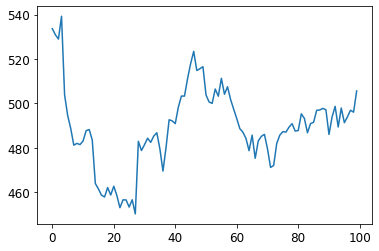

In [6]:
#Plot temp

plt.plot(COSTCO['Close'])
plt.show()

# Data Cleanup

In [7]:
# Remove all null values

COSTCO = COSTCO.dropna().reset_index(drop=True)

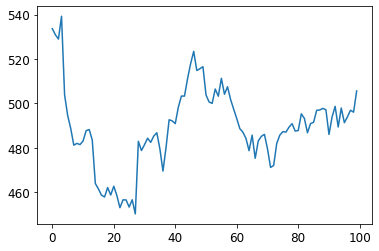

In [8]:
plt.plot(COSTCO['Close'])
plt.show()

## RESHAPE the data set!

In [9]:
COSTCO.shape

(100, 2)

In [10]:
# Note that not all days have 24 readings. Some are missing.

COSTCO.shape[0]/10

10.0

In [11]:
COSTCO.groupby(['Date']).count()

,Close
Date,
2022-11-25,1
2022-11-28,1
2022-11-29,1
2022-11-30,1
2022-12-01,1
...,...
2023-04-14,1
2023-04-17,1
2023-04-18,1


In [12]:
# Re-organize the data set by day and hours

temp = np.array(COSTCO['Close']).reshape(10,10)

temp

array([[533.659973, 530.919983, 528.960022, 539.25    , 503.859985,
        494.529999, 488.660004, 481.160004, 481.970001, 481.420013],
       [483.019989, 487.679993, 488.200012, 483.519989, 463.910004,
        461.450012, 458.630005, 457.820007, 462.059998, 458.709991],
       [462.649994, 458.5     , 452.98999 , 456.529999, 456.5     ,
        453.279999, 456.559998, 450.190002, 482.869995, 478.75    ],
       [481.399994, 484.309998, 482.429993, 485.25    , 486.769989,
        479.470001, 469.48999 , 480.109985, 492.609985, 492.109985],
       [490.880005, 498.299988, 503.290009, 503.279999, 511.140015,
        517.909973, 523.429993, 514.799988, 515.590027, 516.530029],
       [503.809998, 500.630005, 499.98999 , 506.450012, 503.220001,
        511.279999, 504.100006, 507.480011, 501.73999 , 497.390015],
       [493.140015, 488.609985, 487.029999, 484.179993, 478.670013,
        485.690002, 475.26001 , 483.079987, 485.149994, 486.040009],
       [479.519989, 471.140015, 472.     

In [13]:
# Convert to dataframe

temp_df = pd.DataFrame(temp, columns=np.arange(0,10,1))

temp_df

,0,1,2,3,4,5,6,7,8,9
0,533.659973,530.919983,528.960022,539.250000,503.859985,494.529999,488.660004,481.160004,481.970001,481.420013
1,483.019989,487.679993,488.200012,483.519989,463.910004,461.450012,458.630005,457.820007,462.059998,458.709991
2,462.649994,458.500000,452.989990,456.529999,456.500000,453.279999,456.559998,450.190002,482.869995,478.750000
3,481.399994,484.309998,482.429993,485.250000,486.769989,479.470001,469.489990,480.109985,492.609985,492.109985
4,490.880005,498.299988,503.290009,503.279999,511.140015,517.909973,523.429993,514.799988,515.590027,516.530029
5,503.809998,500.630005,499.989990,506.450012,503.220001,511.279999,504.100006,507.480011,501.739990,497.390015
6,493.140015,488.609985,487.029999,484.179993,478.670013,485.690002,475.260010,483.079987,485.149994,486.040009
7,479.519989,471.140015,472.000000,481.920013,485.660004,487.260010,487.049988,489.290009,490.850006,487.519989
8,487.760010,495.269989,493.220001,486.769989,490.869995,491.480011,496.869995,497.029999,497.730011,497.130005
9,485.980011,493.829987,498.649994,489.350006,497.890015,491.299988,493.940002,496.899994,496.029999,505.579987


# Reshape for Standardizing Data

In [14]:
# Let's create a single sequence (i.e., feature) for standardization

temp_1feature = np.array(temp_df).ravel().reshape(-1,1)

temp_1feature.shape

(100, 1)

In [15]:
temp_1feature

array([[533.659973],
       [530.919983],
       [528.960022],
       [539.25    ],
       [503.859985],
       [494.529999],
       [488.660004],
       [481.160004],
       [481.970001],
       [481.420013],
       [483.019989],
       [487.679993],
       [488.200012],
       [483.519989],
       [463.910004],
       [461.450012],
       [458.630005],
       [457.820007],
       [462.059998],
       [458.709991],
       [462.649994],
       [458.5     ],
       [452.98999 ],
       [456.529999],
       [456.5     ],
       [453.279999],
       [456.559998],
       [450.190002],
       [482.869995],
       [478.75    ],
       [481.399994],
       [484.309998],
       [482.429993],
       [485.25    ],
       [486.769989],
       [479.470001],
       [469.48999 ],
       [480.109985],
       [492.609985],
       [492.109985],
       [490.880005],
       [498.299988],
       [503.290009],
       [503.279999],
       [511.140015],
       [517.909973],
       [523.429993],
       [514.7

## Standardize the values

In [16]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

temp_std = scaler.fit_transform(temp_1feature)

## Reshape the data back to 24-hour format

In [17]:
temp_reshaped = temp_std.reshape(10,10)

temp_reshaped.shape

(10, 10)

In [18]:
#Pandas version of the reshaped data

pd.DataFrame(temp_reshaped)

,0,1,2,3,4,5,6,7,8,9
0,2.471019,2.319211,2.210621,2.780732,0.819964,0.303041,-0.022184,-0.437718,-0.392840,-0.423312
1,-0.334666,-0.076481,-0.047669,-0.306964,-1.393446,-1.529741,-1.685982,-1.730860,-1.495945,-1.681551
2,-1.463257,-1.693185,-1.998465,-1.802332,-1.803994,-1.982397,-1.800670,-2.153597,-0.342977,-0.571243
3,-0.424421,-0.263194,-0.367355,-0.211113,-0.126899,-0.531352,-1.084290,-0.495894,0.196663,0.168961
4,0.100814,0.511915,0.788385,0.787830,1.223311,1.598398,1.904232,1.426090,1.469862,1.521942
5,0.817195,0.641009,0.605549,0.963464,0.784506,1.231067,0.833263,1.020530,0.702507,0.461499
6,0.226029,-0.024955,-0.112493,-0.270397,-0.575675,-0.186735,-0.764604,-0.331342,-0.216654,-0.167343
7,-0.528582,-0.992871,-0.945224,-0.395610,-0.188397,-0.099750,-0.111386,0.012721,0.099152,-0.085346
8,-0.072047,0.344039,0.230461,-0.126899,0.100260,0.134057,0.432687,0.441552,0.480336,0.447093
9,-0.170668,0.264257,0.531307,0.016046,0.489201,0.124083,0.270352,0.434349,0.386148,0.915260


# Split the Data

**In certain cases, we cannot use a random split. For example, if we are trying to predict the stock market, we cannot use a random split. We need to use a chronological split.**

BUT, keep in mind if we have something like hourly readings of dayly temperature, we can use a random split on days, but the sequence of the temperature within the day is important to remain sequential.

In this case, we are using a random spli because each day as an independent sample.

In [19]:
from sklearn.model_selection import train_test_split

#train, test = train_test_split(temp_reshaped, test_size=0.3)

# if we neede to maintain the ordering of the data, we can use the following code to split the data
split_point = int(len(temp_reshaped)*0.7)
train, test = temp_reshaped[:split_point], temp_reshaped[split_point:]

In [20]:
train.shape

(7, 10)

In [21]:
train

array([[ 2.47101917,  2.31921126,  2.21062051,  2.78073208,  0.81996433,
         0.30304068, -0.02218373, -0.43771784, -0.39284032, -0.42331215],
       [-0.33466621, -0.0764808 , -0.04766938, -0.30696394, -1.39344627,
        -1.52974101, -1.68598222, -1.7308598 , -1.49594502, -1.68155064],
       [-1.46325656, -1.69318509, -1.9984647 , -1.80233211, -1.80399419,
        -1.98239688, -1.80067002, -2.15359677, -0.34297656, -0.57124302],
       [-0.4244213 , -0.26319384, -0.36735467, -0.21111346, -0.12689916,
        -0.53135169, -1.08428967, -0.49589366,  0.19666318,  0.1689609 ],
       [ 0.10081442,  0.51191521,  0.78838507,  0.78783047,  1.22331109,
         1.59839755,  1.90423176,  1.42609024,  1.46986199,  1.52194238],
       [ 0.81719482,  0.64100875,  0.60554901,  0.9634636 ,  0.78450631,
         1.23106684,  0.83326258,  1.02053023,  0.70250697,  0.46149857],
       [ 0.22602925, -0.02495501, -0.11249342, -0.27039671, -0.57567466,
        -0.18673535, -0.76460433, -0.33134205

In [22]:
test.shape

(3, 10)

# Create Input and Target values

The first 23 hours will be input to predict the 24th hour reading (i.e., target)

In [23]:
# The first 23 columns (from 0 to 22) are inputs

train_inputs = train[:,:9]


pd.DataFrame(train_inputs, columns=np.arange(0,9,1))

,0,1,2,3,4,5,6,7,8
0,2.471019,2.319211,2.210621,2.780732,0.819964,0.303041,-0.022184,-0.437718,-0.392840
1,-0.334666,-0.076481,-0.047669,-0.306964,-1.393446,-1.529741,-1.685982,-1.730860,-1.495945
2,-1.463257,-1.693185,-1.998465,-1.802332,-1.803994,-1.982397,-1.800670,-2.153597,-0.342977
3,-0.424421,-0.263194,-0.367355,-0.211113,-0.126899,-0.531352,-1.084290,-0.495894,0.196663
4,0.100814,0.511915,0.788385,0.787830,1.223311,1.598398,1.904232,1.426090,1.469862
5,0.817195,0.641009,0.605549,0.963464,0.784506,1.231067,0.833263,1.020530,0.702507
6,0.226029,-0.024955,-0.112493,-0.270397,-0.575675,-0.186735,-0.764604,-0.331342,-0.216654


## Add one more dimension to make it ready for RNNs

See here for more details: https://keras.io/layers/recurrent/, and https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


In [24]:
train_inputs

array([[ 2.47101917,  2.31921126,  2.21062051,  2.78073208,  0.81996433,
         0.30304068, -0.02218373, -0.43771784, -0.39284032],
       [-0.33466621, -0.0764808 , -0.04766938, -0.30696394, -1.39344627,
        -1.52974101, -1.68598222, -1.7308598 , -1.49594502],
       [-1.46325656, -1.69318509, -1.9984647 , -1.80233211, -1.80399419,
        -1.98239688, -1.80067002, -2.15359677, -0.34297656],
       [-0.4244213 , -0.26319384, -0.36735467, -0.21111346, -0.12689916,
        -0.53135169, -1.08428967, -0.49589366,  0.19666318],
       [ 0.10081442,  0.51191521,  0.78838507,  0.78783047,  1.22331109,
         1.59839755,  1.90423176,  1.42609024,  1.46986199],
       [ 0.81719482,  0.64100875,  0.60554901,  0.9634636 ,  0.78450631,
         1.23106684,  0.83326258,  1.02053023,  0.70250697],
       [ 0.22602925, -0.02495501, -0.11249342, -0.27039671, -0.57567466,
        -0.18673535, -0.76460433, -0.33134205, -0.21665425]])

In [25]:
train_inputs.shape 

(7, 9)

In [26]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape 

(7, 9, 1)

In [27]:
train_x

array([[[ 2.47101917],
        [ 2.31921126],
        [ 2.21062051],
        [ 2.78073208],
        [ 0.81996433],
        [ 0.30304068],
        [-0.02218373],
        [-0.43771784],
        [-0.39284032]],

       [[-0.33466621],
        [-0.0764808 ],
        [-0.04766938],
        [-0.30696394],
        [-1.39344627],
        [-1.52974101],
        [-1.68598222],
        [-1.7308598 ],
        [-1.49594502]],

       [[-1.46325656],
        [-1.69318509],
        [-1.9984647 ],
        [-1.80233211],
        [-1.80399419],
        [-1.98239688],
        [-1.80067002],
        [-2.15359677],
        [-0.34297656]],

       [[-0.4244213 ],
        [-0.26319384],
        [-0.36735467],
        [-0.21111346],
        [-0.12689916],
        [-0.53135169],
        [-1.08428967],
        [-0.49589366],
        [ 0.19666318]],

       [[ 0.10081442],
        [ 0.51191521],
        [ 0.78838507],
        [ 0.78783047],
        [ 1.22331109],
        [ 1.59839755],
        [ 1.90423176],
   

## Set the target

In [28]:
# The last column (9) is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['9'])

,9
0,-0.423312
1,-1.681551
2,-0.571243
3,0.168961
4,1.521942
5,0.461499
6,-0.167343


## Repeat for TEST

In [29]:
test.shape

(3, 10)

In [30]:
# The first 23 columns (from 0 to 22) are inputs

test_inputs = test[:,:9]

In [31]:
#Create an additional dimension for test

test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(3, 9, 1)

In [32]:
# The last column (23) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['9'])

,9
0,-0.085346
1,0.447093
2,0.915260


In [33]:
performance = pd.DataFrame({"model":[], "MSE":[]})

# A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [34]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9, 1]),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 496ms/step - loss: 0.8830
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 0.8516
Epoch 3/100
1/1 [==============================] - 0s 0s/step - loss: 0.8213
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 0.7916
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 0.7628
Epoch 6/100
1/1 [==============================] - 0s 0s/step - loss: 0.7348
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 0.7070
Epoch 8/100
1/1 [==============================] - 0s 16ms/step - loss: 0.6799
Epoch 9/100
1/1 [==============================] - 0s 0s/step - loss: 0.6537
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6278
Epoch 11/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6025
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.5780
Epoch 13/100
1/1 [==============================] - 0s 13ms

### Predictions

In [35]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 75ms/step


In [36]:
# Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [37]:
comparison

,actual,predicted
0,487.519989,492.902466
1,497.130005,493.335205
2,505.579987,494.068665


In [38]:
MSE = mean_squared_error(comparison['actual'], comparison['predicted'])

In [39]:
performance = pd.concat([performance,pd.DataFrame({'model': 'Normal NN', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,58.627369


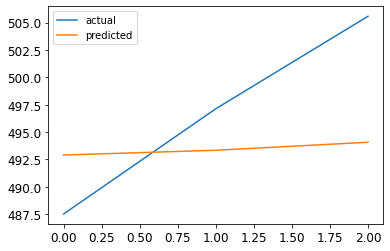

In [40]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Simple RNN

Simplest recurrent neural network

In [41]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 1s 867ms/step - loss: 0.5577
Epoch 2/30
1/1 [==============================] - 0s 6ms/step - loss: 0.5277
Epoch 3/30
1/1 [==============================] - 0s 13ms/step - loss: 0.4989
Epoch 4/30
1/1 [==============================] - 0s 15ms/step - loss: 0.4711
Epoch 5/30
1/1 [==============================] - 0s 7ms/step - loss: 0.4422
Epoch 6/30
1/1 [==============================] - 0s 5ms/step - loss: 0.4133
Epoch 7/30
1/1 [==============================] - 0s 18ms/step - loss: 0.3850
Epoch 8/30
1/1 [==============================] - 0s 13ms/step - loss: 0.3580
Epoch 9/30
1/1 [==============================] - 0s 7ms/step - loss: 0.3319
Epoch 10/30
1/1 [==============================] - 0s 16ms/step - loss: 0.3071
Epoch 11/30
1/1 [==============================] - 0s 11ms/step - loss: 0.2869
Epoch 12/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2675
Epoch 13/30
1/1 [==============================] - 0s 11ms/step -

### Predictions

In [43]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 128ms/step


In [44]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [45]:
comparison

,actual,predicted
0,487.519989,491.865662
1,497.130005,495.997009
2,505.579987,495.482025


In [46]:
MSE = mean_squared_error(comparison['actual'], comparison['predicted'])

In [47]:
performance = pd.concat([performance,pd.DataFrame({'model': 'simple RNN', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,58.627369
0,simple RNN,40.712461


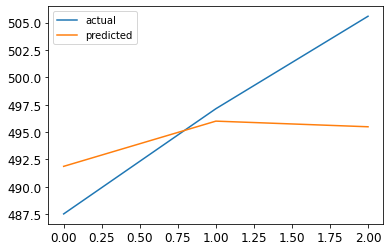

In [48]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

## Simple RNN with more layers

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training. However, if the output of RNN is sent to a DENSE layer, then a single value should be sent. That's why there is no "return sequences" right before DENSE layers.**

In [49]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 1.9125
Epoch 2/30
1/1 [==============================] - 0s 12ms/step - loss: 1.6542
Epoch 3/30
1/1 [==============================] - 0s 10ms/step - loss: 1.4588
Epoch 4/30
1/1 [==============================] - 0s 15ms/step - loss: 1.2944
Epoch 5/30
1/1 [==============================] - 0s 3ms/step - loss: 1.1595
Epoch 6/30
1/1 [==============================] - 0s 4ms/step - loss: 1.0615
Epoch 7/30
1/1 [==============================] - 0s 19ms/step - loss: 0.9797
Epoch 8/30
1/1 [==============================] - 0s 19ms/step - loss: 0.9063
Epoch 9/30
1/1 [==============================] - 0s 16ms/step - loss: 0.8428
Epoch 10/30
1/1 [==============================] - 0s 12ms/step - loss: 0.7933
Epoch 11/30
1/1 [==============================] - 0s 10ms/step - loss: 0.7483
Epoch 12/30
1/1 [==============================] - 0s 12ms/step - loss: 0.7077
Epoch 13/30
1/1 [==============================] - 0s 13ms/step -

### Predictions

In [51]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 212ms/step


In [52]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [53]:
comparison

,actual,predicted
0,487.519989,488.505005
1,497.130005,492.837158
2,505.579987,492.184998


In [54]:
MSE = mean_squared_error(comparison['actual'], comparison['predicted'])

In [55]:
performance = pd.concat([performance,pd.DataFrame({'model': 'simple RNN with more layers', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,58.627369
0,simple RNN,40.712461
0,simple RNN with more layers,66.274844


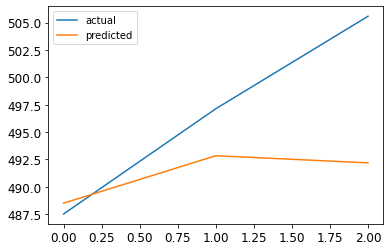

In [56]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [57]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.7564
Epoch 2/30
1/1 [==============================] - 0s 4ms/step - loss: 0.7409
Epoch 3/30
1/1 [==============================] - 0s 0s/step - loss: 0.7256
Epoch 4/30
1/1 [==============================] - 0s 966us/step - loss: 0.7105
Epoch 5/30
1/1 [==============================] - 0s 22ms/step - loss: 0.6957
Epoch 6/30
1/1 [==============================] - 0s 17ms/step - loss: 0.6812
Epoch 7/30
1/1 [==============================] - 0s 19ms/step - loss: 0.6670
Epoch 8/30
1/1 [==============================] - 0s 17ms/step - loss: 0.6530
Epoch 9/30
1/1 [==============================] - 0s 17ms/step - loss: 0.6394
Epoch 10/30
1/1 [==============================] - 0s 18ms/step - loss: 0.6259
Epoch 11/30
1/1 [==============================] - 0s 16ms/step - loss: 0.6128
Epoch 12/30
1/1 [==============================] - 0s 17ms/step - loss: 0.5998
Epoch 13/30
1/1 [==============================] - 0s 15ms/step -

### Predictions

In [59]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 140ms/step


In [60]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [61]:
comparison

,actual,predicted
0,487.519989,486.659729
1,497.130005,491.172760
2,505.579987,491.302338


In [62]:
MSE = mean_squared_error(comparison['actual'], comparison['predicted'])

In [63]:
performance = pd.concat([performance,pd.DataFrame({'model': 'LSTM RNN', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,58.627369
0,simple RNN,40.712461
0,simple RNN with more layers,66.274844
0,LSTM RNN,80.026695


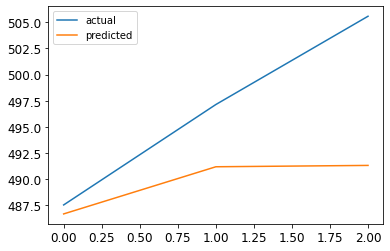

In [64]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [65]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [66]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 0.8015
Epoch 2/30
1/1 [==============================] - 0s 16ms/step - loss: 0.7692
Epoch 3/30
1/1 [==============================] - 0s 17ms/step - loss: 0.7385
Epoch 4/30
1/1 [==============================] - 0s 23ms/step - loss: 0.7093
Epoch 5/30
1/1 [==============================] - 0s 15ms/step - loss: 0.6817
Epoch 6/30
1/1 [==============================] - 0s 19ms/step - loss: 0.6558
Epoch 7/30
1/1 [==============================] - 0s 18ms/step - loss: 0.6316
Epoch 8/30
1/1 [==============================] - 0s 16ms/step - loss: 0.6093
Epoch 9/30
1/1 [==============================] - 0s 18ms/step - loss: 0.5892
Epoch 10/30
1/1 [==============================] - 0s 19ms/step - loss: 0.5713
Epoch 11/30
1/1 [==============================] - 0s 18ms/step - loss: 0.5559
Epoch 12/30
1/1 [==============================] - 0s 20ms/step - loss: 0.5431
Epoch 13/30
1/1 [==============================] - 0s 19ms/step

### Predictions

In [67]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 1s 670ms/step


In [68]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [69]:
comparison

,actual,predicted
0,487.519989,485.339081
1,497.130005,491.381866
2,505.579987,491.962708


In [70]:
MSE = mean_squared_error(comparison['actual'], comparison['predicted'])

In [71]:
performance = pd.concat([performance,pd.DataFrame({'model': 'LSTM RNN with more layers', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,58.627369
0,simple RNN,40.712461
0,simple RNN with more layers,66.274844
0,LSTM RNN,80.026695
0,LSTM RNN with more layers,74.409253


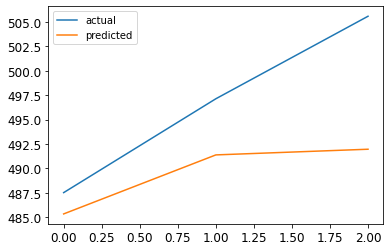

In [72]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [73]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [74]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.8444
Epoch 2/30
1/1 [==============================] - 0s 16ms/step - loss: 0.7761
Epoch 3/30
1/1 [==============================] - 0s 16ms/step - loss: 0.7289
Epoch 4/30
1/1 [==============================] - 0s 4ms/step - loss: 0.6897
Epoch 5/30
1/1 [==============================] - 0s 17ms/step - loss: 0.6550
Epoch 6/30
1/1 [==============================] - 0s 16ms/step - loss: 0.6238
Epoch 7/30
1/1 [==============================] - 0s 17ms/step - loss: 0.5943
Epoch 8/30
1/1 [==============================] - 0s 17ms/step - loss: 0.5626
Epoch 9/30
1/1 [==============================] - 0s 17ms/step - loss: 0.5336
Epoch 10/30
1/1 [==============================] - 0s 17ms/step - loss: 0.5071
Epoch 11/30
1/1 [==============================] - 0s 19ms/step - loss: 0.4831
Epoch 12/30
1/1 [==============================] - 0s 17ms/step - loss: 0.4610
Epoch 13/30
1/1 [==============================] - 0s 13ms/step 

### Predictions

In [75]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 263ms/step


In [76]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [77]:
MSE = mean_squared_error(comparison['actual'], comparison['predicted'])

In [78]:
performance = pd.concat([performance,pd.DataFrame({'model': 'GRU with more layers', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,58.627369
0,simple RNN,40.712461
0,simple RNN with more layers,66.274844
0,LSTM RNN,80.026695
0,LSTM RNN with more layers,74.409253
0,GRU with more layers,57.830242


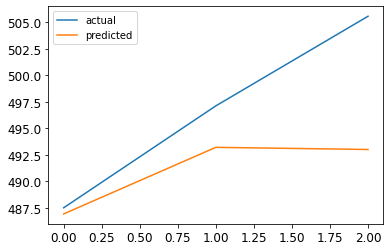

In [79]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [80]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [81]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 0.8929
Epoch 2/30
1/1 [==============================] - 0s 14ms/step - loss: 0.8501
Epoch 3/30
1/1 [==============================] - 0s 15ms/step - loss: 0.8098
Epoch 4/30
1/1 [==============================] - 0s 16ms/step - loss: 0.7720
Epoch 5/30
1/1 [==============================] - 0s 16ms/step - loss: 0.7385
Epoch 6/30
1/1 [==============================] - 0s 16ms/step - loss: 0.7055
Epoch 7/30
1/1 [==============================] - 0s 18ms/step - loss: 0.6746
Epoch 8/30
1/1 [==============================] - 0s 15ms/step - loss: 0.6452
Epoch 9/30
1/1 [==============================] - 0s 15ms/step - loss: 0.6176
Epoch 10/30
1/1 [==============================] - 0s 16ms/step - loss: 0.5908
Epoch 11/30
1/1 [==============================] - 0s 22ms/step - loss: 0.5650
Epoch 12/30
1/1 [==============================] - 0s 12ms/step - loss: 0.5401
Epoch 13/30
1/1 [==============================] - 0s 17ms/step

### Predictions

In [82]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 269ms/step


In [83]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [84]:
MSE = mean_squared_error(comparison['actual'], comparison['predicted'])

In [85]:
performance = pd.concat([performance,pd.DataFrame({'model': 'Conv1D', 'MSE':MSE}, index=[0])])
performance

,model,MSE
0,Normal NN,58.627369
0,simple RNN,40.712461
0,simple RNN with more layers,66.274844
0,LSTM RNN,80.026695
0,LSTM RNN with more layers,74.409253
0,GRU with more layers,57.830242
0,Conv1D,52.838375


In [86]:
performance.sort_values(by='MSE')

,model,MSE
0,simple RNN,40.712461
0,Conv1D,52.838375
0,GRU with more layers,57.830242
0,Normal NN,58.627369
0,simple RNN with more layers,66.274844
0,LSTM RNN with more layers,74.409253
0,LSTM RNN,80.026695


In genral lower the MSE is the better performing model, So from the above performed models we can say that simple RNN
model is the better performing model with 40.71.